In [14]:
import shutil
from google.colab import drive
drive.flush_and_unmount()
shutil.rmtree('/content/drive', ignore_errors=True)

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
dataset_path = "/content/drive/MyDrive/Infosys/css-data"

In [17]:
!pwd

/content


In [18]:
!ls /content/drive/MyDrive/Infosys/css-data

class_names.txt  README.dataset.txt   train
css-data.yaml	 README.roboflow.txt  traintestsplit_FAST
data.yaml	 test		      valid


In [13]:
yaml_path = "/content/drive/MyDrive/Infosys/css-data/data.yaml"
new_yaml = """train: /content/drive/MyDrive/Infosys/css-data/train/images
val: /content/drive/MyDrive/Infosys/css-data/valid/images
test: /content/drive/MyDrive/Infosys/css-data/test/images

nc: 10
names: [
  "person",
  "helmet",
  "vest",
  "gloves",
  "boots",
  "mask",
  "goggles",
  "no-helmet",
  "no-vest",
  "no-gloves"
]
"""
with open(yaml_path, "w") as f:
    f.write(new_yaml)
print("YAML file updated successfully at:", yaml_path)

YAML file updated successfully at: /content/drive/MyDrive/Infosys/css-data/data.yaml


In [14]:
!cat /content/drive/MyDrive/Infosys/css-data/data.yaml

train: /content/drive/MyDrive/Infosys/css-data/train/images
val: /content/drive/MyDrive/Infosys/css-data/valid/images
test: /content/drive/MyDrive/Infosys/css-data/test/images

nc: 10
names: [
  "person",
  "helmet",
  "vest",
  "gloves",
  "boots",
  "mask",
  "goggles",
  "no-helmet",
  "no-vest",
  "no-gloves"
]


In [28]:
classnames_path = "/content/drive/MyDrive/Infosys/css-data/class_names.txt"
class_names = [
    "person",
    "helmet",
    "vest",
    "gloves",
    "boots",
    "mask",
    "goggles",
    "no-helmet",
    "no-vest",
    "no-gloves"
]
with open(classnames_path, "w") as f:
    for name in class_names:
        f.write(name + "\n")
print("Class_names.txt updated successfully at:", classnames_path)


Class_names.txt updated successfully at: /content/drive/MyDrive/Infosys/css-data/class_names.txt


In [21]:
import yaml, glob
yaml_path = "/content/drive/MyDrive/Infosys/css-data/data.yaml"
label_dir = "/content/drive/MyDrive/Infosys/css-data/train/labels"
with open(yaml_path, "r") as f:
    data = yaml.safe_load(f)
ids = set()
for file in glob.glob(f"{label_dir}/*.txt"):
    with open(file) as f:
        for line in f:
            if line.strip():
                ids.add(int(line.split()[0]))
print("YAML classes:", data["names"])
print("Total classes in YAML:", data["nc"])
print("Unique class IDs in dataset:", sorted(ids))

YAML classes: ['person', 'helmet', 'vest', 'gloves', 'boots', 'mask', 'goggles', 'no-helmet', 'no-vest', 'no-gloves']
Total classes in YAML: 10
Unique class IDs in dataset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [24]:
import os
base = "/content/drive/MyDrive/Infosys/scripts"
os.makedirs(base, exist_ok=True)
for f in ["check_annotations.py", "visualize_boxes.py", "clean_dataset.py"]:
    open(os.path.join(base, f), "w").close()
print("Folder and scripts created at:", base)

Folder and scripts created at: /content/drive/MyDrive/Infosys/scripts


In [25]:
!ls -l /content/drive/MyDrive/Infosys/scripts

total 0
-rw------- 1 root root 0 Oct  7 17:26 check_annotations.py
-rw------- 1 root root 0 Oct  7 17:26 clean_dataset.py
-rw------- 1 root root 0 Oct  7 17:26 visualize_boxes.py


Annotations

In [1]:
import os
from tqdm import tqdm

def check_annotations(images_dir, labels_dir, invalid_dir, class_names):
    os.makedirs(invalid_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    invalid_count = 0

    for label_file in tqdm(os.listdir(labels_dir)):
        if not label_file.endswith(".txt"):
            continue

        label_path = os.path.join(labels_dir, label_file)
        with open(label_path, "r") as f:
            lines = f.readlines()

        bad = False
        reason = ""

        if len(lines) == 0:
            bad = True
            reason = "EMPTY FILE"

        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                bad = True
                reason = "INVALID FORMAT"
                break
            try:
                cls_id = int(parts[0])
                if cls_id < 0 or cls_id >= len(class_names):
                    bad = True
                    reason = f"INVALID CLASS ID ({cls_id})"
                    break
                coords = [float(x) for x in parts[1:]]
                if any(c < 0 or c > 1 for c in coords):
                    bad = True
                    reason = f"OUT OF RANGE COORDS: {coords}"
                    break
            except ValueError:
                bad = True
                reason = "NON-NUMERIC VALUE"
                break

        if bad:
            invalid_count += 1
            print(f"{label_file} → {reason}")
            os.rename(label_path, os.path.join(invalid_dir, label_file))

    print(f"\nDone checking. {invalid_count} invalid label(s) moved to: {invalid_dir}")

if __name__ == "__main__":
    images_dir = "/content/drive/MyDrive/Infosys/css-data/train/images"
    labels_dir = "/content/drive/MyDrive/Infosys/css-data/train/labels"
    invalid_dir = "/content/drive/MyDrive/Infosys/css-data/labels_invalid"
    class_names = [
        "person", "helmet", "vest", "gloves", "boots",
        "mask", "goggles", "no-helmet", "no-vest", "no-gloves"
    ]
    check_annotations(images_dir, labels_dir, invalid_dir, class_names)


100%|██████████| 2599/2599 [00:40<00:00, 63.91it/s] 


Done checking. 0 invalid label(s) moved to: /content/drive/MyDrive/Infosys/css-data/labels_invalid


In [2]:
import os
import cv2
from tqdm import tqdm
def load_classes(path):
    with open(path, "r") as f:
        return [line.strip() for line in f.readlines() if line.strip()]
def check_annotations(images_dir, labels_dir, invalid_dir, class_file):
    classes = load_classes(class_file)
    os.makedirs(invalid_dir, exist_ok=True)
    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    label_files = set(os.listdir(labels_dir))
    invalid_count = 0
    missing_count = 0
    print("Checking annotations...\n")
    for img_file in tqdm(image_files):
        img_name = os.path.splitext(img_file)[0]
        label_path = os.path.join(labels_dir, f"{img_name}.txt")
        if not os.path.exists(label_path):
            print(f"[MISSING LABEL] → {img_file}")
            missing_count += 1
            continue
        img_path = os.path.join(images_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"[CORRUPTED IMAGE] → {img_file}")
            continue
        h, w = img.shape[:2]
        with open(label_path, "r") as f:
            lines = [line.strip() for line in f.readlines() if line.strip()]
        if len(lines) == 0:
            print(f"[EMPTY LABEL] → {label_path}")
            os.rename(label_path, os.path.join(invalid_dir, os.path.basename(label_path)))
            invalid_count += 1
            continue
        seen_boxes = set()
        valid = True
        reason = ""
        for line in lines:
            parts = line.split()
            if len(parts) != 5:
                valid = False
                reason = "INVALID FORMAT"
                break
            try:
                cls_id = int(parts[0])
                x, y, bw, bh = map(float, parts[1:])
            except ValueError:
                valid = False
                reason = "NON-NUMERIC VALUE"
                break
            if cls_id < 0 or cls_id >= len(classes):
                valid = False
                reason = f"INVALID CLASS ID ({cls_id})"
                break
            if not (0 <= x <= 1 and 0 <= y <= 1 and 0 < bw <= 1 and 0 < bh <= 1):
                valid = False
                reason = f"OUT OF RANGE BBOX ({x}, {y}, {bw}, {bh})"
                break
            if line in seen_boxes:
                valid = False
                reason = "DUPLICATE BOX"
                break
            seen_boxes.add(line)
        if not valid:
            print(f"{label_path} → {reason}")
            os.rename(label_path, os.path.join(invalid_dir, os.path.basename(label_path)))
            invalid_count += 1
    print("\nAnnotation check complete!")
    print(f"Invalid labels moved to: {invalid_dir}")
    print(f"Missing labels: {missing_count}")
    print(f"Invalid labels: {invalid_count}")
if __name__ == "__main__":
    images_dir = "/content/drive/MyDrive/Infosys/css-data/train/images"
    labels_dir = "/content/drive/MyDrive/Infosys/css-data/train/labels"
    invalid_dir = "/content/drive/MyDrive/Infosys/css-data/scripts/labels_invalid"
    class_file = "/content/drive/MyDrive/Infosys/css-data/class_names.txt"
    check_annotations(images_dir, labels_dir, invalid_dir, class_file)

Checking annotations...



 12%|█▏        | 306/2618 [00:41<00:37, 61.72it/s]

[MISSING LABEL] → youtube-175_jpg.rf.42efa8b28ba1ccb4779c2b169023c27d (1).jpg


 14%|█▍        | 362/2618 [00:42<00:34, 65.08it/s]

[MISSING LABEL] → youtube-196_jpg.rf.d9d5913fb05f3dfcc17d19e54e9ecbf6.jpg


 16%|█▌        | 412/2618 [00:43<00:33, 65.65it/s]

[MISSING LABEL] → youtube-197_jpg.rf.84e48afd1eb2f504aecfb6456a196950.jpg


 42%|████▏     | 1107/2618 [00:54<00:21, 69.65it/s]

[MISSING LABEL] → amz_04178_png_jpg.rf.66878feb10ab848f3eb8cba2f05f0c31 (1).jpg
[MISSING LABEL] → amz_02354_png_jpg.rf.05804b93377b6f8d38b6e61553c4c129 (1).jpg
[MISSING LABEL] → airport_inside_0550_jpg.rf.e4d7eb4a0f8870365fb2518f58e17459 (1).jpg


 44%|████▎     | 1144/2618 [00:55<00:21, 67.21it/s]

[MISSING LABEL] → amz_01638_png_jpg.rf.fc30c65fb3c1e97e7114ecb396a1004b (1).jpg
[MISSING LABEL] → amz_02354_png_jpg.rf.d74fcc68ca92923700f106656525292d (1).jpg


 45%|████▌     | 1181/2618 [00:56<00:21, 66.15it/s]

[MISSING LABEL] → amz_04178_png_jpg.rf.4313b414c237d190af0ad60830b5bd4c (1).jpg
[MISSING LABEL] → amz_04178_png_jpg.rf.88d441f41b0483c66b08e900051c62e8 (1).jpg
[MISSING LABEL] → amz_04178_png_jpg.rf.4da0ffe1b77c2dd1e122ab212d27b525 (1).jpg


 47%|████▋     | 1218/2618 [00:56<00:21, 65.78it/s]

[MISSING LABEL] → amz_02354_png_jpg.rf.a3aba4dcbc962e937a2b590392aec320 (1).jpg
[MISSING LABEL] → amz_02354_png_jpg.rf.6f192e3fc3461a07887582a6e44fd46e (1).jpg


 48%|████▊     | 1263/2618 [00:57<00:19, 69.12it/s]

[MISSING LABEL] → amz_02354_png_jpg.rf.921443ff67fe49b2185683dd5bbca1f1 (1).jpg
[MISSING LABEL] → airport_inside_0550_jpg.rf.56385e14f5f45b8e32f1bde53ce0fec3 (1).jpg


 55%|█████▍    | 1427/2618 [00:59<00:18, 64.27it/s]

[MISSING LABEL] → construction-1-_mp4-115_jpg.rf.7afe87b728c11bfa2d6616ef75081e4c.jpg


 60%|█████▉    | 1569/2618 [01:02<00:16, 64.04it/s]

[MISSING LABEL] → construction-5-_mp4-30_jpg.rf.f671ac8915234f2ca8b9246d095055e9.jpg


 62%|██████▏   | 1626/2618 [01:03<00:16, 61.62it/s]

[MISSING LABEL] → construction-4-_mp4-19_jpg.rf.b39073990b499b99dfe415a49fdb90bb.jpg


 67%|██████▋   | 1745/2618 [01:05<00:14, 61.41it/s]

/content/drive/MyDrive/Infosys/css-data/train/labels/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.txt → DUPLICATE BOX


 67%|██████▋   | 1759/2618 [01:05<00:14, 61.24it/s]

[MISSING LABEL] → construction-821-_jpg.rf.098b834846b3be5f1b24ef6dbc3a30a4.jpg


 78%|███████▊  | 2032/2618 [01:09<00:10, 57.57it/s]

/content/drive/MyDrive/Infosys/css-data/train/labels/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.txt → DUPLICATE BOX


100%|██████████| 2618/2618 [01:19<00:00, 32.84it/s]


Annotation check complete!
Invalid labels moved to: /content/drive/MyDrive/Infosys/css-data/labels_invalid
Missing labels: 19
Invalid labels: 2


Visualisations

Found 2618 images. Generating visualizations...


Drawing boxes: 100%|██████████| 2618/2618 [02:50<00:00, 15.38it/s]



All annotated images saved to: /content/drive/MyDrive/Infosys/css-data/visualization/samples


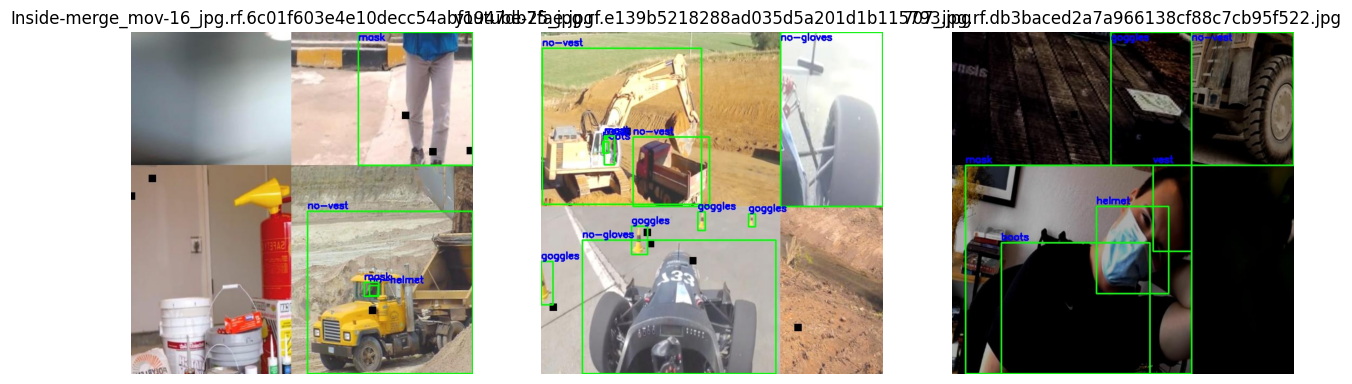

In [2]:
import cv2
import os
import random
import glob
from matplotlib import pyplot as plt
from tqdm import tqdm
def load_classes(path):
    with open(path, "r") as f:
        return [line.strip() for line in f.readlines() if line.strip()]
def draw_boxes(image_path, label_path, class_file, save_dir=None):
    classes = load_classes(class_file)
    img = cv2.imread(image_path)
    if img is None:
        print(f"Could not read image: {image_path}")
        return None
    h, w = img.shape[:2]
    if not os.path.exists(label_path):
        return None
    with open(label_path, "r") as f:
        lines = [line.strip() for line in f.readlines() if line.strip()]
    for line in lines:
        parts = line.split()
        if len(parts) != 5:
            print(f"Invalid label format in {label_path}")
            continue
        try:
            cls_id, x, y, bw, bh = map(float, parts)
            cls_id = int(cls_id)
        except ValueError:
            print(f"Non-numeric label in {label_path}")
            continue
        x1 = int((x - bw / 2) * w)
        y1 = int((y - bh / 2) * h)
        x2 = int((x + bw / 2) * w)
        y2 = int((y + bh / 2) * h)
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w - 1, x2), min(h - 1, y2)
        color = (0, 255, 0)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        label = classes[cls_id] if cls_id < len(classes) else f"ID:{cls_id}"
        cv2.putText(img, label, (x1, max(15, y1 - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, os.path.basename(image_path))
        cv2.imwrite(out_path, img)
    return img
def visualize_dataset(img_dir, label_dir, class_file, save_dir, sample_count=10):
    image_paths = []
    for ext in ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]:
        image_paths.extend(glob.glob(os.path.join(img_dir, ext)))
    image_paths = sorted(image_paths)
    if not image_paths:
        print("No images found.")
        return
    print(f"Found {len(image_paths)} images. Generating visualizations...")
    for img_path in tqdm(image_paths, desc="Drawing boxes"):
        img_name = os.path.basename(img_path)
        label_name = os.path.splitext(img_name)[0] + ".txt"
        label_path = os.path.join(label_dir, label_name)
        draw_boxes(img_path, label_path, class_file, save_dir)
    print(f"\nAll annotated images saved to: {save_dir}")
    sample_images = random.sample(image_paths, min(sample_count, len(image_paths)))
    plt.figure(figsize=(15, 10))
    for i, img_path in enumerate(sample_images):
        vis_path = os.path.join(save_dir, os.path.basename(img_path))
        img = cv2.imread(vis_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, sample_count, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(os.path.basename(img_path))
    plt.show()
if __name__ == "__main__":
    img_dir = "/content/drive/MyDrive/Infosys/css-data/train/images"
    label_dir = "/content/drive/MyDrive/Infosys/css-data/train/labels"
    class_file = "/content/drive/MyDrive/Infosys/css-data/class_names.txt"
    save_dir = "/content/drive/MyDrive/Infosys/css-data/scripts/visualization/samples"
    visualize_dataset(img_dir, label_dir, class_file, save_dir, sample_count=3)

Clean Images

In [3]:
import os
import shutil
import cv2
from tqdm import tqdm
def clean_dataset(images_path, labels_path, out_path, removed_path, invalid_path):
    os.makedirs(out_path, exist_ok=True)
    os.makedirs(removed_path, exist_ok=True)
    os.makedirs(invalid_path, exist_ok=True)
    for lbl in os.listdir(labels_path):
        lbl_path = os.path.join(labels_path, lbl)
        if lbl.endswith(".txt") and "INVALID" in lbl.upper():
            shutil.move(lbl_path, os.path.join(invalid_path, lbl))
    for img_file in tqdm(os.listdir(images_path), desc="Cleaning images"):
        if not img_file.lower().endswith((".jpg", ".jpeg", ".png")):
            continue
        img_path = os.path.join(images_path, img_file)
        label_file = os.path.splitext(img_file)[0] + ".txt"
        label_path = os.path.join(labels_path, label_file)
        img = cv2.imread(img_path)
        if img is None:
            print(f"[CORRUPTED IMAGE] {img_file}")
            shutil.move(img_path, os.path.join(removed_path, img_file))
            continue
        if not os.path.exists(label_path):
            print(f"[NO LABEL] {img_file}")
            shutil.move(img_path, os.path.join(removed_path, img_file))
            continue
        if os.path.getsize(label_path) == 0:
            print(f"[EMPTY LABEL] {label_file}")
            shutil.move(img_path, os.path.join(removed_path, img_file))
            shutil.move(label_path, os.path.join(invalid_path, label_file))
            continue
        shutil.copy(img_path, os.path.join(out_path, img_file))
        shutil.copy(label_path, os.path.join(out_path, label_file))
    for lbl_file in os.listdir(labels_path):
        lbl_path = os.path.join(labels_path, lbl_file)
        if not lbl_file.lower().endswith(".txt"):
            continue
        corresponding_img = os.path.splitext(lbl_file)[0]
        found_image = False
        for ext in [".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG"]:
            if os.path.exists(os.path.join(images_path, corresponding_img + ext)):
                found_image = True
                break
        if not found_image:
            print(f"[LABEL WITHOUT IMAGE] {lbl_file}")
            shutil.move(lbl_path, os.path.join(invalid_path, lbl_file))
    print("\nDataset cleaned successfully!")
    print(f"Cleaned files → {out_path}")
    print(f"Removed images → {removed_path}")
    print(f"Invalid labels → {invalid_path}")
if __name__ == "__main__":
    images_path = "/content/drive/MyDrive/Infosys/css-data/train/images"
    labels_path = "/content/drive/MyDrive/Infosys/css-data/train/labels"
    out_path = "/content/drive/MyDrive/Infosys/css-data/scripts/annotations_cleaned/train"
    removed_path = "/content/drive/MyDrive/Infosys/css-data/images_removed"
    invalid_path = "/content/drive/MyDrive/Infosys/css-data/labels_invalid"
    clean_dataset(images_path, labels_path, out_path, removed_path, invalid_path)

Cleaning images:  11%|█▏        | 297/2618 [01:00<01:48, 21.47it/s]

[NO LABEL] youtube-175_jpg.rf.42efa8b28ba1ccb4779c2b169023c27d (1).jpg


Cleaning images:  14%|█▎        | 357/2618 [01:03<01:50, 20.45it/s]

[NO LABEL] youtube-196_jpg.rf.d9d5913fb05f3dfcc17d19e54e9ecbf6.jpg


Cleaning images:  15%|█▌        | 402/2618 [01:06<01:54, 19.33it/s]

[NO LABEL] youtube-197_jpg.rf.84e48afd1eb2f504aecfb6456a196950.jpg


Cleaning images:  42%|████▏     | 1098/2618 [01:43<01:12, 20.84it/s]

[NO LABEL] amz_04178_png_jpg.rf.66878feb10ab848f3eb8cba2f05f0c31 (1).jpg
[NO LABEL] amz_02354_png_jpg.rf.05804b93377b6f8d38b6e61553c4c129 (1).jpg


Cleaning images:  42%|████▏     | 1104/2618 [01:44<01:14, 20.25it/s]

[NO LABEL] airport_inside_0550_jpg.rf.e4d7eb4a0f8870365fb2518f58e17459 (1).jpg


Cleaning images:  43%|████▎     | 1134/2618 [01:45<01:10, 21.20it/s]

[NO LABEL] amz_01638_png_jpg.rf.fc30c65fb3c1e97e7114ecb396a1004b (1).jpg


Cleaning images:  44%|████▍     | 1146/2618 [01:46<01:06, 21.99it/s]

[NO LABEL] amz_02354_png_jpg.rf.d74fcc68ca92923700f106656525292d (1).jpg


Cleaning images:  45%|████▍     | 1173/2618 [01:47<01:02, 23.27it/s]

[NO LABEL] amz_04178_png_jpg.rf.4313b414c237d190af0ad60830b5bd4c (1).jpg
[NO LABEL] amz_04178_png_jpg.rf.88d441f41b0483c66b08e900051c62e8 (1).jpg


Cleaning images:  45%|████▌     | 1179/2618 [01:47<01:08, 21.14it/s]

[NO LABEL] amz_04178_png_jpg.rf.4da0ffe1b77c2dd1e122ab212d27b525 (1).jpg


Cleaning images:  46%|████▌     | 1206/2618 [01:49<01:12, 19.54it/s]

[NO LABEL] amz_02354_png_jpg.rf.a3aba4dcbc962e937a2b590392aec320 (1).jpg


Cleaning images:  46%|████▋     | 1215/2618 [01:49<01:21, 17.20it/s]

[NO LABEL] amz_02354_png_jpg.rf.6f192e3fc3461a07887582a6e44fd46e (1).jpg


Cleaning images:  48%|████▊     | 1249/2618 [01:51<01:04, 21.38it/s]

[NO LABEL] amz_02354_png_jpg.rf.921443ff67fe49b2185683dd5bbca1f1 (1).jpg


Cleaning images:  48%|████▊     | 1256/2618 [01:51<00:59, 22.81it/s]

[NO LABEL] airport_inside_0550_jpg.rf.56385e14f5f45b8e32f1bde53ce0fec3 (1).jpg


Cleaning images:  54%|█████▍    | 1420/2618 [02:00<01:00, 19.76it/s]

[NO LABEL] construction-1-_mp4-115_jpg.rf.7afe87b728c11bfa2d6616ef75081e4c.jpg


Cleaning images:  60%|█████▉    | 1563/2618 [02:08<01:20, 13.14it/s]

[NO LABEL] construction-5-_mp4-30_jpg.rf.f671ac8915234f2ca8b9246d095055e9.jpg


Cleaning images:  62%|██████▏   | 1619/2618 [02:12<00:50, 19.65it/s]

[NO LABEL] construction-4-_mp4-19_jpg.rf.b39073990b499b99dfe415a49fdb90bb.jpg


Cleaning images:  66%|██████▋   | 1738/2618 [02:23<01:44,  8.41it/s]

[NO LABEL] construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg


Cleaning images:  67%|██████▋   | 1753/2618 [02:26<02:43,  5.31it/s]

[NO LABEL] construction-821-_jpg.rf.098b834846b3be5f1b24ef6dbc3a30a4.jpg


Cleaning images:  77%|███████▋  | 2027/2618 [02:44<00:30, 19.24it/s]

[NO LABEL] 004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg


Cleaning images: 100%|██████████| 2618/2618 [03:16<00:00, 13.33it/s]



Dataset cleaned successfully!
Cleaned files → /content/drive/MyDrive/Infosys/css-data/annotations_cleaned/train
Removed images → /content/drive/MyDrive/Infosys/css-data/images_removed
Invalid labels → /content/drive/MyDrive/Infosys/css-data/labels_invalid
